In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from numpy import linalg as LA
from numpy.linalg import inv
from libsvm.svm import svm_problem, svm_parameter
from libsvm.svmutil import svm_train, svm_predict

# Data processing

In [2]:
# chose 25 folders randomly
chosen = np.random.default_rng(2022).choice(np.arange(1, 68 + 1), 25, replace=False)

# Load images 
images = []
labels = []

directory = Path("/Python_programme/Jupyter/PIE_origin")
for i in chosen:
    # split train and test
    sub_images = []
    sub_labels = []
    sub_directory = directory / str(i)
    
    files = list(sub_directory.glob("*.jpg"))
    np.random.default_rng(2023).shuffle(files)
    for filename in files:
        im = Image.open(filename)
        sub_images.append(np.array(im))
        sub_labels.append(i)  # Use folder numbers as labels
    images.append(sub_images)
    labels.append(sub_labels)
    
# len(images)
# len(labels)

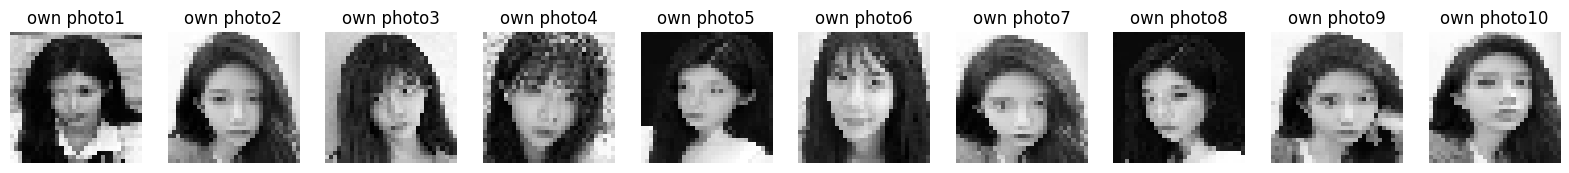

In [3]:
# process own photos
own_imgs= []
own_labels = []

for i in range(1, 11):
    img = cv2.imread('/Python_programme/Jupyter/own_photos/'+ str(i)+'.jpg', cv2.IMREAD_GRAYSCALE)  # convert to gray image
    img = cv2.resize(img, (32, 32), interpolation = cv2.INTER_CUBIC)
    own_imgs.append(img)   # create imgs in desired format
    own_labels.append(69)  # label own photos as class 69
    
# split training and testing data sets 
own_train_imgs = own_imgs[0:7]      # first 7 phots for training
own_test_imgs = own_imgs[7:]        # last 3 photos for testing
own_train_labels = own_labels[0:7]  
own_test_labels = own_labels[7:]

# visualize photos
fig = plt.figure(figsize = (20,10))

for i in range(1, 11):
    plt.subplot(1, 10, i)
    plt.imshow(own_imgs[i-1], cmap = 'gray' )
    plt.title('own photo'+ str(i))
    plt.axis('off')
    
plt.show()

In [4]:
# Train-test split
NUM_TRAIN_IMAGES_PER_SUBJECT = np.int_(np.around(0.7 * 170))

images_train, images_test = np.split(np.array(images), [NUM_TRAIN_IMAGES_PER_SUBJECT], axis=1)
labels_train, labels_test = np.split(np.array(labels), [NUM_TRAIN_IMAGES_PER_SUBJECT], axis=1)
own_images_train, own_images_test = np.split(np.array(own_imgs), [7])
own_labels_train, own_labels_test = np.split(np.array(own_labels), [7])

import warnings
warnings.filterwarnings('ignore', category=Warning)

# Flatterning
PIE_images_train = images_train.reshape(25*NUM_TRAIN_IMAGES_PER_SUBJECT, 1024)
own_images_train = own_images_train.reshape(7, 1024)
images_test = images_test.reshape(25*(170-NUM_TRAIN_IMAGES_PER_SUBJECT), 1024)
own_images_test = own_images_test.reshape(3, 1024)

labels_train = labels_train.reshape(25*NUM_TRAIN_IMAGES_PER_SUBJECT)
labels_test = labels_test.reshape(25*(170-NUM_TRAIN_IMAGES_PER_SUBJECT))

# Combine PIE images and own photos to get full train and test sets
full_train_set = np.append(PIE_images_train,own_images_train,axis=0,)
full_train_labels = np.append(labels_train, own_labels_train)

full_test_set = np.append(images_test,own_images_test,axis=0,)
full_test_labels = np.append(labels_test, own_labels_test)

# SVM

## 1. compute SVM parameters

In [6]:
X_train = full_train_set
y_train = full_train_labels

mean_X = np.mean(X_train, axis=0)
centered_X = X_train - mean_X

u, s, vh = np.linalg.svd(centered_X, full_matrices=False)
s_matrix = np.diag(s)

# max components: 200
X_pca = u[:, :200] @ s_matrix[:200, :200]
total_mean_X_test = np.mean(full_test_set, axis=0)
total_centered_X_test = full_test_set - total_mean_X_test
# projection for test set
full_X_pca_test = total_centered_X_test @ vh.T[:, :200]

In [7]:
def svmC(c, prob, raw):
    print("For penalty parameter C = " + str(c) + ":")
    param = svm_parameter("-t 0 -c " + str(c))
    m = svm_train(prob, param)
    if raw:
        p_label, p_acc, p_val = svm_predict(full_test_labels, full_test_set, m)
    else:
        p_label, p_acc, p_val = svm_predict(full_test_labels, full_X_pca_test, m)
        
def svm(X, y, raw):
    prob = svm_problem(y, X)
    # Vary C
    svmC(1e-2, prob, raw)
    svmC(1e-1, prob, raw)
    svmC(1, prob, raw)

## 2. classification accuracy on raw images for different C

In [8]:
print("Use raw face images (vectorized):")
svm(X_train, y_train, True)

Use raw face images (vectorized):
For penalty parameter C = 0.01:
Accuracy = 98.2003% (1255/1278) (classification)
For penalty parameter C = 0.1:
Accuracy = 98.2003% (1255/1278) (classification)
For penalty parameter C = 1:
Accuracy = 98.2003% (1255/1278) (classification)


## 3. classification accuracy on face vectors after PCA pre-processing with dimensionality of 80 for different C

In [9]:
print("Use face vectors after PCA pre-processing with dimensionality of 80: ")
svm(X_pca[:, :80], y_train, False)

Use face vectors after PCA pre-processing with dimensionality of 80: 
For penalty parameter C = 0.01:
Accuracy = 97.5743% (1247/1278) (classification)
For penalty parameter C = 0.1:
Accuracy = 97.5743% (1247/1278) (classification)
For penalty parameter C = 1:
Accuracy = 97.5743% (1247/1278) (classification)


## 4. classification accuracy on face vectors after PCA pre-processing with dimensionality of 200 for different C

In [10]:
print("Use face vectors after PCA pre-processing with dimensionality of 200: ")
svm(X_pca[:, :200], y_train, False)

Use face vectors after PCA pre-processing with dimensionality of 200: 
For penalty parameter C = 0.01:
Accuracy = 97.9656% (1252/1278) (classification)
For penalty parameter C = 0.1:
Accuracy = 97.9656% (1252/1278) (classification)
For penalty parameter C = 1:
Accuracy = 97.9656% (1252/1278) (classification)
